In [384]:
%env CUDA_VISIBLE_DEVICES=1
%load_ext autoreload

env: CUDA_VISIBLE_DEVICES=1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
sys.path.append('../../../')

import numpy as np
import matplotlib.pyplot as plt

from SeismicPro.seismicpro.src import SeismicDataset, Survey, MetricMap
from SeismicPro.seismicpro.src.gather import FirstBreaksOutliers
from SeismicPro.seismicpro.src.metrics import PipelineMetric, pass_coords, pass_batch, pass_calc_args
from SeismicPro.seismicpro.batchflow import B, V, F, L, Pipeline
from SeismicPro.seismicpro.src.gather.utils import convert_mask_to_pick
from batchflow.models.torch import TorchModel
from SeismicPro.seismicpro.batchflow.models.torch import UNet, ResBlock

import warnings
warnings.filterwarnings("ignore")

In [355]:
sgy_path = '../processing_/data/test_g_coord.sgy'
picking_path = "../processing_/data/VAY22_picking"
save_breaks_path = "../processing_/data/VAY22_predicted_breaks_1d"
save_2d_breaks_path = "../processing_/data/VAY22_predicted_breaks_2d"
breaks_2d_path = '../processing_/data/picking_v3_max'
save_model_path = '../processing_/data/2d_unet'

BATCH_SIZE = 512
N_EPOCHS = 15

In [4]:
def plot_loss(loss):
    plt.figure(figsize=(25, 6))
    plt.grid()
    plt.plot(loss)
    plt.title('Loss history during training', fontsize=16)
    plt.xlabel('Iteration', fontsize=16)
    plt.ylabel('BDice Loss', fontsize=16)
    plt.show()

Define all necessery imports

## Dataset

Initialize surveys and load first breaks

In [5]:
header_cols = ['TraceNumber', "INLINE_3D", "CROSSLINE_3D", "offset", "SourceX", "SourceY", "GroupX", "GroupY", "CDP_X", "CDP_Y"]
survey = Survey(sgy_path, header_index='FieldRecord', header_cols=header_cols, name='raw')

survey.load_first_breaks(picking_path, inplace=True, first_breaks_col='FirstBreak')
survey.load_first_breaks(save_breaks_path, inplace=True, first_breaks_col='FirstBreak1D')

Trace headers loaded:   0%|          | 0/58706100 [00:00<?, ?it/s]

In [13]:
survey.reindex(['FieldRecord', 'INLINE_3D'], inplace=True)

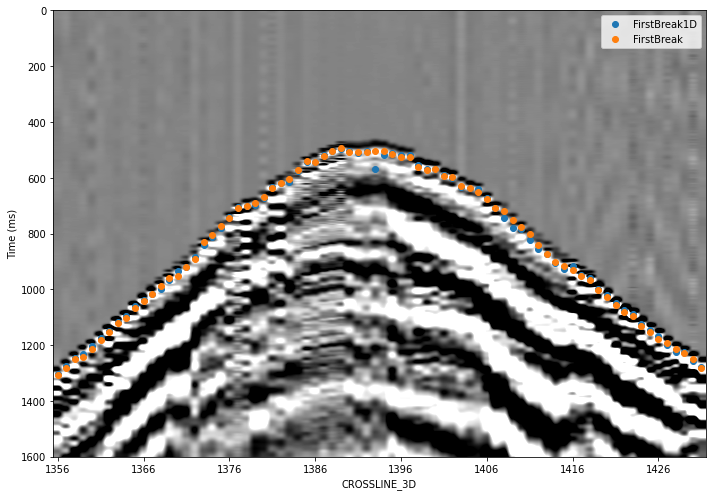

In [19]:
survey.sample_gather().sort(by='CROSSLINE_3D').plot(event_headers=['FirstBreak1D', 'FirstBreak'])

In [20]:
dataset = SeismicDataset(survey)
dataset.split(shuffle=True)

In [27]:
dataset = dataset.reindex(['FieldRecord', 'INLINE_3D'], inplace=True)

In [28]:
dataset.test.size, dataset.train.size

(307, 1227)

## Model Architecture
Specify model config, optimizer and loss function. We use UNet-based architecture consisting of two parts - encoder and decoder. Both of them are based on ResNet-like models with Concurrent Spatial and Channel Squeeze & Excitation attention blocks.

In [270]:
def get_unet_resblock_config(n_layers, crop_shape=(1, 800), scale_factor=1):
    block_channels = [
                        [16, 16, 64], 
                        [16, 16, 128],
                        [32, 32, 256],
                        [64, 64, 512]]
    
    branch_channels = [64, 128, 256, 512]
    if scale_factor != 1:
        branch_channels = [(channels // scale_factor) for channels in branch_channels]
        block_channels = (np.array(block_channels) // scale_factor).tolist()
        
    autoencoder_res_unet_n_config = {
        'inputs_shapes': crop_shape,

        'order': ['encoder', 'embedding', 'decoder', 'head'],


        'encoder': { 'type': 'encoder',
                     'order': ['block', 'skip'],
                     'num_stages': n_layers,
                     'blocks': { 'layout': 'Rcna cna cnS+a',
                                 'kernel_size': [1, 3, 1],
                                 'padding': [0, 1, 0],
                                 'stride': [2, 1, 1],
                                 'channels': block_channels[:n_layers], # HW: (400, 200, 100, 50)
                                 'bias': False,
                                 'attention': 'se',

                                 'branch': {'layout': 'vcn',  
                                            'pool_size': 2,
                                            'pool_stride': 2,
                                            'kernel_size': 1,
                                            'stride': 1,
                                            'padding': 0,
                                            'channels': branch_channels[:n_layers],
                                            'bias': False
                                            },
                                },
                    'output_type': 'list'
                   },
        'embedding': {
                    'input_type': 'list',
                    'input_idx': 3,
                    'output_type': 'list',
                    'layout': 'Rcna cna cnS+a',
                    'kernel_size': 3,
                    'padding': 'same',
                    'channels': branch_channels[n_layers - 1] * 2,
                    'bias': False,
                    'attention': 'se',

                    'branch': {'layout': 'cn', 
                               'kernel_size': 1,
                               'padding': 'same',
                               'stride': 1,
                               'channels': branch_channels[n_layers - 1] * 2, # C: (64, 128, 256, 1024)
                               'bias': False
                              },
                      },

        'decoder': {
            'skip': True,
            'input_type': 'list',
            'indices': [3, 2, 1, 0],
            'type': 'decoder',
            'num_stages': n_layers,
            'order': ['block', 'combine', 'upsample'],
            'blocks': {'layout': 'Rcna cna cnS+a', 
                       'channels':  branch_channels[n_layers - 1::-1] , 
                       'kernel_size': 3, 
                       'stride': 1,
                       'padding': 'same',
                       'bias': False,
                       'attention': 'se',
                       
                       'branch': {'layout': 'cn',  
                                            'kernel_size': 1,
                                            'stride': 1,
                                            'padding': 0,
                                            'channels': branch_channels[n_layers - 1::-1],
                                            'bias': False
                                            },
                      },
            'combine': {'op': 'concat', 'force_resize': False, },

            'upsample': {'layout': 't', 'kernel_size': 2, 'stride': 2, 'channels': 'same // 2', 'bias': True}
        },
        'head': {
            'layout': 'c', 'channels': 1, 'kernel_size': 1, 'stride': 1, 'padding': 0, 'bias': True
        },

        'loss': 'bdice', 
        'model_class': TorchModel,
        'output': 'sigmoid',
        'optimizer': {'name': 'Adam', 'lr': 1e-3},
        'device': 'gpu:0',

    }
    return autoencoder_res_unet_n_config

batchflow_model = TorchModel(get_unet_resblock_config(n_layers=4, scale_factor=8, crop_shape=(1, 16, 256)))
batchflow_model.repr(2)

Network(
    (encoder): EncoderModule(
        (block-0:  (?,   1,  16, 256)  ⟶ (?,   8,   8, 128))
        (skip-0:   (?,   8,   8, 128)  ⟶ (?,   8,   8, 128))
        (block-1:  (?,   8,   8, 128)  ⟶ (?,  16,   4,  64))
        (skip-1:   (?,  16,   4,  64)  ⟶ (?,  16,   4,  64))
        (block-2:  (?,  16,   4,  64)  ⟶ (?,  32,   2,  32))
        (skip-2:   (?,  32,   2,  32)  ⟶ (?,  32,   2,  32))
        (block-3:  (?,  32,   2,  32)  ⟶ (?,  64,   1,  16))
        (skip-3:   (?,  64,   1,  16)  ⟶ (?,  64,   1,  16))
    )
    (embedding: [(?,   8,   8, 128),
                 (?,  16,   4,  64),
                 (?,  32,   2,  32),
                 (?,  64,   1,  16),
                 (?,  64,   1,  16)] ⟶ [(?,   8,   8, 128),
                                         (?,  16,   4,  64),
                                         (?,  32,   2,  32),
                                         (?,  64,   1,  16),
                                         (?,  64,   1,  16),
               

## Training
Define training pipeline that contains all procedures from data loading to model training. This pipeline runs for 5 epochs.

In [275]:
train_notifier = {
    'bar': 'n', 'frequency': 1,
    'graphs': ['loss_history']
}

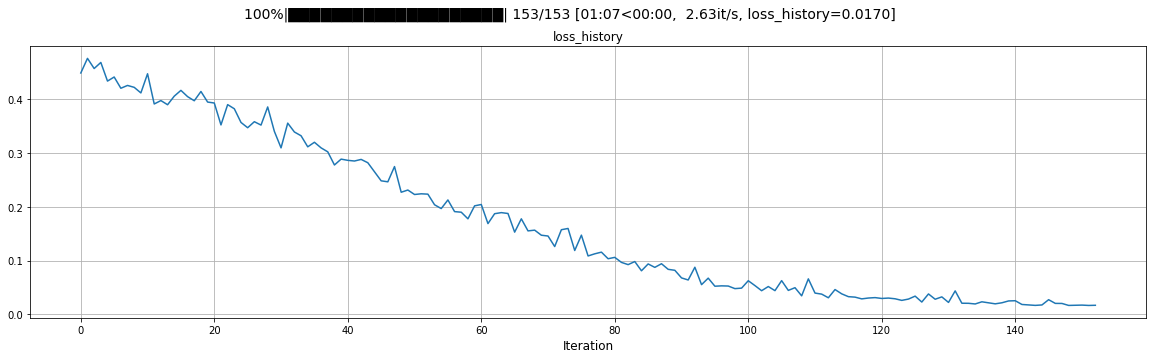

In [276]:
crop_shape = (16, 256)

model_config = get_unet_resblock_config(n_layers=4, crop_shape=(1, *crop_shape), scale_factor=8)

train_template = (Pipeline()
    # initializing the model and auxiliary variable
    .add_namespace(np)
    .init_variable('loss_history', [])
    .init_model('fbp_model', config=model_config)
        
    # data preprocessing
    .load(src='raw', combined=False)
    .sort(src='raw', by='CROSSLINE_3D')
    
    # crop inputs from 1D mask
    .pick_to_mask(src='raw', first_breaks_col='FirstBreak1D', dst='mask1D')
    .crop(src='mask1D', origins='grid', crop_shape=crop_shape, stride=(5, 200), dst='crops')
    .make_model_inputs(src=L('crops').crops, dst='inputs', expand_dims_axis=1)
    .update(V('inputs', mode='w'), B('inputs'))

    # true mask
    .pick_to_mask(src='raw', first_breaks_col='FirstBreak', dst='mask')
    .crop(src='mask', origins='grid', crop_shape=crop_shape, stride=(5, 200), dst='mask')
    .make_model_inputs(src=L('mask').crops, dst='mask', expand_dims_axis=1)
    
    # model training and loss accumulating
    .train_model('fbp_model', outputs='loss', inputs=L('inputs'),
                 targets=L('mask'), save_to=V('loss_history', mode='a'))
    )

train_pipeline = train_template << dataset.train
train_pipeline.run(batch_size=8, n_epochs=1, drop_last=True, shuffle=True, notifier=train_notifier)

In [356]:
train_pipeline.save_model_now(name='fbp_model', path=save_model_path)

## Inference

Measure model's quality as a module of the distance between predicted and real times of first break. To convert binary mask to picking we use ```mask_to_pick``` method that defines the first break as the beginning of the longest sequence of signal samples in a mask.

In [330]:
val_template = (Pipeline()
    # initializing the model and auxiliary variable
    .add_namespace(np)
    .import_model('fbp_model', source=train_pipeline)
    .init_variable('mae', [])
    
    # data preprocessing
    .load(src='raw', combined=False)
    .sort(src='raw', by='CROSSLINE_3D')
    
    # crop inputs from 1D mask
    .pick_to_mask(src='raw', first_breaks_col='FirstBreak1D', dst='mask1D')
    .crop(src='mask1D', origins='grid', crop_shape=crop_shape, stride=(5, 200), dst='crops')
    .make_model_inputs(src=L('crops').crops, dst='inputs', expand_dims_axis=1)

    # true mask
    .pick_to_mask(src='raw', first_breaks_col='FirstBreak', dst='mask')
    .crop(src='mask', origins='grid', crop_shape=crop_shape, stride=(5, 200), dst='mask')
    .make_model_inputs(src=L('mask').crops, dst='mask', expand_dims_axis=1)
                
    # model prediction
    .predict_model('fbp_model', inputs=L('inputs'), outputs='sigmoid', save_to=L('predicted_masks'))
    
    # result prostprocessing
    
    # .convert_mask_to_pick(L('predicted_masks').squeeze(), samples=np.arange(0, 1600, 2), threshold=0.5, save_to=V('predicted_times', mode='w'))
    .split_model_outputs(src=L('predicted_masks').squeeze(), dst=L('crops').crops, shapes=L('crops').crops.shape[0])
    .assemble_gather(src='crops', dst='gather')
    .mask_to_pick(src='gather', first_breaks_col='PredictedBreak')
    .mean(abs(B('gather')[0]['PredictedBreak'] - B('gather')[0]['FirstBreak']), save_to=V('mae', mode='a'))
)

val_pipeline = val_template << dataset.test
val_pipeline.run(batch_size=1, n_iters=50, drop_last=True, shuffle=False, bar='n')

  0%|                                                                                                         …

In [331]:
print(f"Mean absolute error is {np.mean(val_pipeline.v('mae')):.2f} samples") 

Mean absolute error is 9.94 samples


## Model evaluation
Let's visualize the predictions of the model. Firstly, reindex the dataset by FieldRecord, in order to make predictions for gathers, not for traces.

In [332]:
dataset_inference = dataset.test.copy()

In [27]:
dataset_inference.index.reindex('FieldRecord', inplace=True)

In [522]:
plot_pipeline_template = (Pipeline()
    .import_model('fbp_model', train_pipeline)
                          
    # data preprocessing
    .load(src='raw', combined=False)
    .sort(src='raw', by='CROSSLINE_3D')
    
    # crop inputs from 1D mask
    .pick_to_mask(src='raw', first_breaks_col='FirstBreak1D', dst='mask1D')
    .crop(src='mask1D', origins='grid', crop_shape=crop_shape, stride=(5, 200), dst='crops')
    .make_model_inputs(src=L('crops').crops, dst='inputs', expand_dims_axis=1)
                
    # model prediction
    .predict_model('fbp_model', inputs=L('inputs'), outputs='sigmoid', save_to=L('predicted_masks'))
    # result prostprocessing
    
    .split_model_outputs(src=L('predicted_masks').squeeze(), dst=L('crops').crops, shapes=L('crops').crops.shape[0])
    .assemble_gather(src='crops', dst='gather')
    .mask_to_pick(src='gather', first_breaks_col='PredictedBreak', save_to='raw')
    .plot(src='raw', event_headers=['FirstBreak', 'FirstBreak1D', 'PredictedBreak'], figsize=(6, 6), max_width=12)
)

plot_pipeline = plot_pipeline_template << dataset_inference

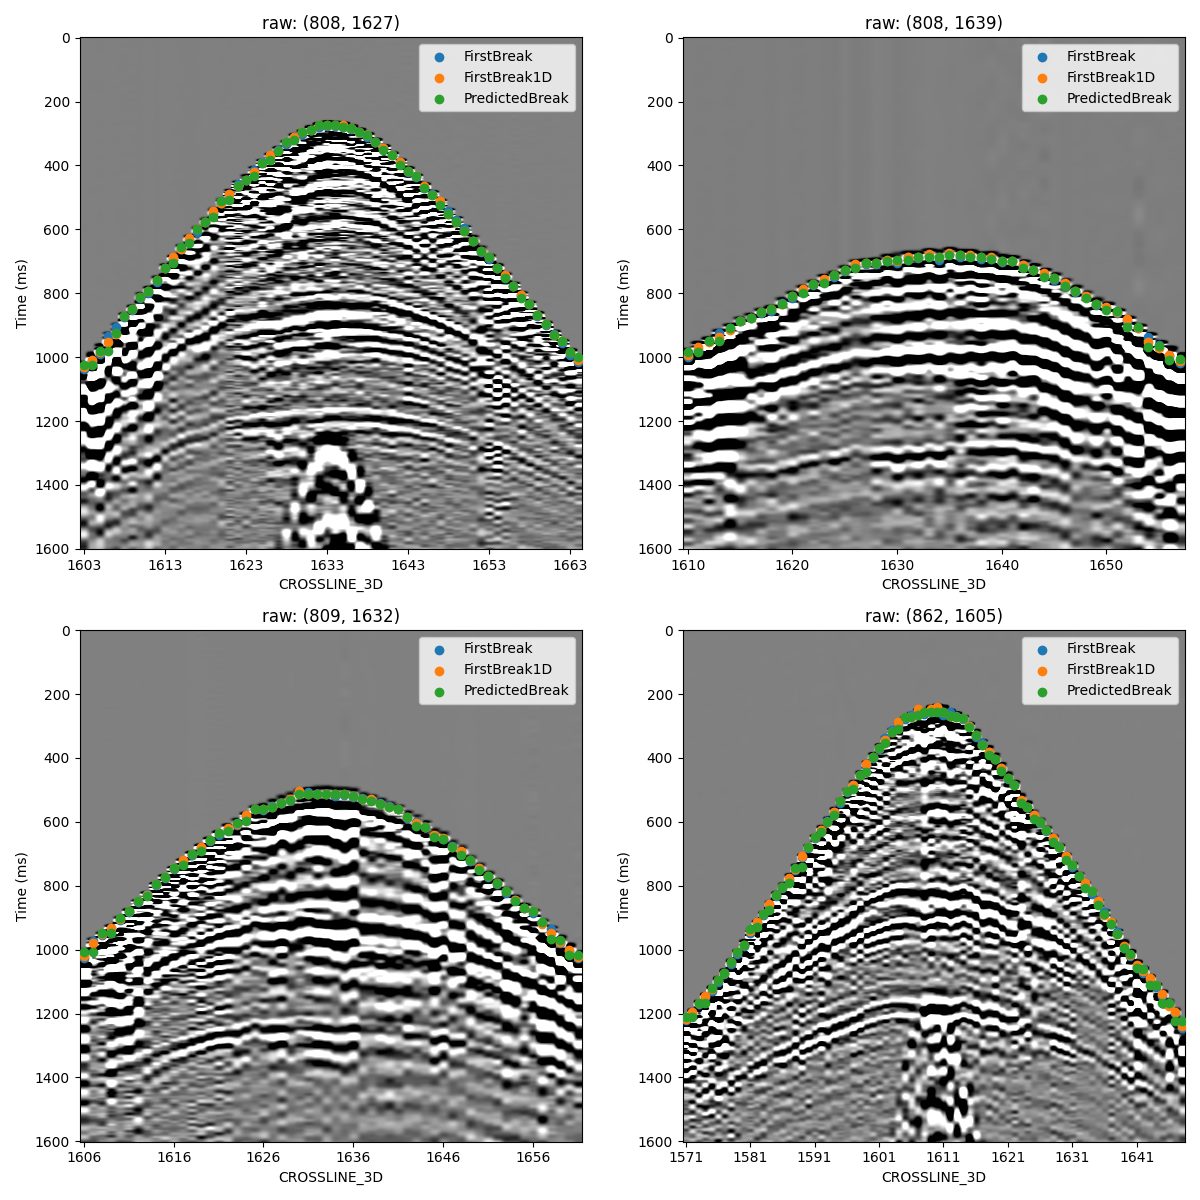

In [523]:
batch = plot_pipeline.next_batch(batch_size=4)

## Save Predictions

In [357]:
header_cols = ["INLINE_3D", "CROSSLINE_3D", 'TraceNumber', 'FieldRecord',  "offset"]
survey = Survey(sgy_path, header_index=['FieldRecord', 'INLINE_3D'], header_cols=header_cols, name='full')

Trace headers loaded:   0%|          | 0/58706100 [00:00<?, ?it/s]

In [358]:
survey.load_first_breaks(save_breaks_path, inplace=True, first_breaks_col='FirstBreak1D')

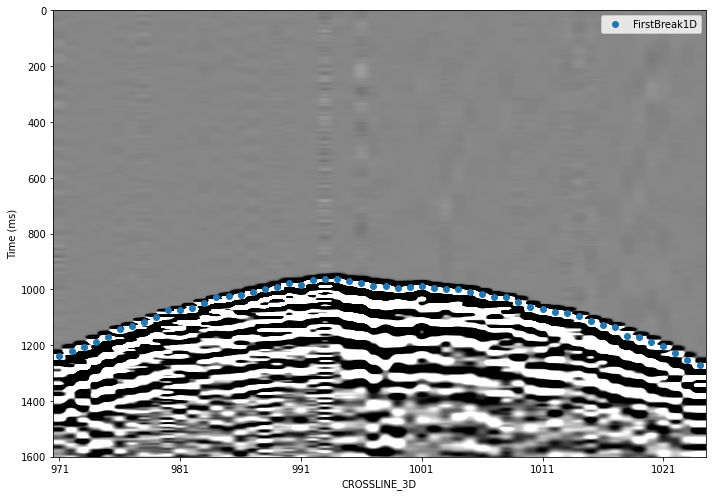

In [368]:
survey.sample_gather().sort(by="CROSSLINE_3D").plot(event_headers='FirstBreak1D')

In [369]:
dataset = SeismicDataset(survey)

In [370]:
dataset.reindex(['FieldRecord', 'INLINE_3D'], inplace=True)

In [371]:
len(dataset)

951369

In [372]:
save_pipeline_template = (Pipeline()
                          .load_model('fbp_model', path=save_model_path, model_class=TorchModel)
                          
                          .load(src='full', combined=False)
                          .sort(src='full', by='CROSSLINE_3D')
    
                            # crop inputs from 1D mask
                          .pick_to_mask(src='full', first_breaks_col='FirstBreak1D', dst='mask1D')
                          .crop(src='mask1D', origins='grid', crop_shape=crop_shape, stride=(5, 200), dst='crops')
                          .make_model_inputs(src=L('crops').crops, dst='inputs', expand_dims_axis=1)
                          # model prediction
                          .predict_model('fbp_model', inputs=L('inputs'), outputs='sigmoid', save_to=L('predicted_masks'))
                          # result prostprocessing
                          .split_model_outputs(src=L('predicted_masks').squeeze(), dst=L('crops').crops, shapes=L('crops').crops.shape[0])
                          .assemble_gather(src='crops', dst='gather')
                          .mask_to_pick(src='gather', first_breaks_col='PredictedBreak', dst='full')
                          
                          
                          .dump_first_breaks(src='full', path=f'{save_2d_breaks_path}', trace_id_cols=('FieldRecord', 'TraceNumber'), first_breaks_col='PredictedBreak')
                         )

In [ ]:
save_pipeline = save_pipeline_template << dataset

save_pipeline.run(n_epochs=1, batch_size=50, bar='n')

  0%|                                                                                                         …

In [ ]:
survey.load_first_breaks(path=f'{save_2d_breaks_path}', trace_id_cols=('FieldRecord', 'TraceNumber'), first_breaks_col='PredictedBreak', inplace=True)

In [ ]:
survey.headers

In [ ]:
g = survey.sample_gather()
g.sort(by='CROSSLINE_3D')
g.plot(event_headers=['PredictedBreak', 'FirstBreak1D'])

## MetricMap

In [385]:
%matplotlib widget

In [403]:
header_cols = ['TraceNumber', 'FieldRecord', 'offset', 'TRACE_SEQUENCE_FILE',
               "INLINE_3D", "CROSSLINE_3D", "offset", "SourceX", "SourceY", "GroupX", "GroupY", "CDP_X", "CDP_Y"]
survey = Survey(sgy_path, header_index=['FieldRecord'], header_cols=header_cols, name='full')

Trace headers loaded:   0%|          | 0/58706100 [00:00<?, ?it/s]

In [404]:
len(survey.headers)

58706100

In [446]:
survey.load_first_breaks(path=save_breaks_path,  trace_id_cols=('FieldRecord', 'TraceNumber'), first_breaks_col='FirstBreak1D', inplace=True)
survey.load_first_breaks(path=save_2d_breaks_path, trace_id_cols=('FieldRecord', 'TraceNumber'), first_breaks_col='FirstBreak2D', inplace=True)

survey.load_first_breaks(path=breaks_2d_path,  trace_id_cols=('FieldRecord', 'TraceNumber'), first_breaks_col='Nekit_FirstBreak2D', inplace=True)

In [ ]:
survey_small = survey.copy()

In [456]:
indices = np.random.choice(survey.headers.index.unique(), size=5000)

survey_small.headers = survey.headers[survey.headers.index.isin(indices)]

In [457]:
len(survey_small.headers)

3971748

In [462]:
map_dataset = SeismicDataset(survey_small)

In [463]:
map_dataset.reindex(['FieldRecord'], inplace=True)

In [464]:
len(map_dataset)

4835

In [465]:
metrics_pipeline_template = (Pipeline()
                             .init_variable('accumulator_1d')
                             .init_variable('accumulator_2d')
                             .init_variable('accumulator_old_2d')
                             
                             .load(src='full', combined=False)
                             
                             .calculate_refractor_velocity(src='full', n_refractors=2, first_breaks_col='FirstBreak1D', dst='refractor_velocity_1d') 
                             .calculate_refractor_velocity(src='full', n_refractors=2, first_breaks_col='FirstBreak2D', dst='refractor_velocity_2d')
                             .calculate_refractor_velocity(src='full', n_refractors=2, first_breaks_col='Nekit_FirstBreak2D', dst='refractor_velocity_old_2d')
                             
                             .calculate_metric(FirstBreaksOutliers, gather="full", 
                                               refractor_velocity=B('refractor_velocity_1d') ,
                                               first_breaks_col='FirstBreak1D', save_to=V("accumulator_1d", mode="a"))
                             .calculate_metric(FirstBreaksOutliers, gather="full", 
                                               refractor_velocity=B('refractor_velocity_2d') ,
                                               first_breaks_col='FirstBreak2D', save_to=V("accumulator_2d", mode="a"))
                             .calculate_metric(FirstBreaksOutliers, gather="full", 
                                               refractor_velocity=B('refractor_velocity_old_2d') ,
                                               first_breaks_col='Nekit_FirstBreak2D', save_to=V("accumulator_old_2d", mode="a"))
                            )
                            

In [466]:
metrics_pipeline = metrics_pipeline_template << map_dataset

metrics_pipeline.run(batch_size=64, n_epochs=1, bar='n')

  0%|                                                                                                         …

In [467]:
mmap_1d = metrics_pipeline.v('accumulator_1d').construct_map()

In [468]:
mmap_1d.plot(interactive=True)

In [469]:
mmap_2d = metrics_pipeline.v('accumulator_2d').construct_map()

In [470]:
mmap_2d.plot(interactive=True)

In [471]:
mmap_2d_old = metrics_pipeline.v('accumulator_old_2d').construct_map()

In [472]:
mmap_2d_old.plot(interactive=True)